In this notebook, I'm trying to work out how to create a classifier that inherits from LGBMModel with focal loss as objective function. The implementatiom of focal loss is borrowed from [Max's blog](https://maxhalford.github.io/blog/lightgbm-focal-loss/). 

In [87]:
import pandas as pd
from scipy.io import arff
import numpy as np
import lightgbm as lgb


In [88]:
# load data

data = arff.loadarff('phpKo8OWT.arff')
df = pd.DataFrame(data[0])
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,b'0'
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,b'0'
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,b'0'
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,b'0'
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,b'0'


In [90]:
from sklearn import model_selection
X = df.drop('Class', axis=1)
y = df['Class']
y = y.map({b'0': 0, b'1':1})

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=42)



# Logloss implementation

First let's try to make this work for binary logloss

In [91]:
from scipy import special
from sklearn import metrics

def logloss_init_score(y):
    p = y.mean()
    p = np.clip(p, 1e-15, 1 - 1e-15)
    log_odds = np.log(p / (1 - p))
    return log_odds

def logloss_objective(preds, train_data):
    y = train_data.get_label()
    p = special.expit(preds)
    grad = p - y
    hess = p * (1 - p)
    return grad, hess

def logloss_metric(preds, train_data):
    y = train_data.get_label()
    p = special.expit(preds)
    is_higher_better = False
    return 'logloss', metrics.log_loss(y, p), is_higher_better


In [92]:
# this is the default way of training a lightgbm model
# IMPORTANT NOTE: we need to set objective and learning rate explicitly so we can get the same result
params = {
    'objective': 'binary',
    'learning_rate': 0.01,
    'random_seed': 0 }

train_set = lgb.Dataset(data=X_train, label=y_train)
model = lgb.train(params=params, train_set=train_set, valid_sets=train_set)
y_pred = model.predict(X_test)
print(f"Test ROC AUC: {metrics.roc_auc_score(y_test, y_pred):.5f}")
print(f"Test logloss {metrics.log_loss(y_test, y_pred):.5f}")

[LightGBM] [Info] Number of positive: 379, number of negative: 213226
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 213605, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001774 -> initscore=-6.332572
[LightGBM] [Info] Start training from score -6.332572
Test ROC AUC: 0.97091
Test logloss 0.00327


In [6]:
# 

params = {
        'learning_rate': 0.01,
          'random_seed': 0,
          'objective': logloss_objective
}
init_scores = np.full_like(y_train, logloss_init_score(y_train), dtype=float)
train_set = lgb.Dataset(data=X_train, label=y_train, init_score=init_scores)
model = lgb.train(params=params, train_set=train_set, feval=logloss_metric)
y_pred = special.expit(logloss_init_score(y_train)+model.predict(X_test))
print(f"Test ROC AUC: {metrics.roc_auc_score(y_test, y_pred):.5f}")
print(f"Test logloss {metrics.log_loss(y_test, y_pred):.5f}")


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 213605, number of used features: 30
[LightGBM] [Warning] Using self-defined objective function
Test ROC AUC: 0.97091
Test logloss 0.00327


In [96]:
# 

model = lgb.LGBMClassifier()
params = {"objective": 'binary', "learning_rate": 0.01, "random_seed": 0}
model.set_params(**params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Test ROC AUC: {metrics.roc_auc_score(y_test, y_pred):.5f}")
print(f"Test logloss {metrics.log_loss(y_test, y_pred):.5f}")

[LightGBM] [Info] Number of positive: 379, number of negative: 213226
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 213605, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001774 -> initscore=-6.332572
[LightGBM] [Info] Start training from score -6.332572
Test ROC AUC: 0.84510
Test logloss 0.01892


In [348]:
from lightgbm import LGBMModel
from lightgbm.compat import SKLEARN_INSTALLED, LGBMNotFittedError, _LGBMClassifierBase
from lightgbm.callback import _EvalResultDict, record_evaluation

class CustomLGBMClassifier(_LGBMClassifierBase, LGBMModel):


    def __is_fitted__(self):
        return getattr(self, "fitted_", False)

    def get_params(self, deep: bool = True):
        
        params = super().get_params(deep=deep)

        if hasattr(self, "obj_alpha"):
            params.update({"obj_alpha": self.obj_alpha})
        if hasattr(self, "obj_gamma"):
            params.update({"obj_gamma": self.obj_gamma})        
        # self.objective = params["objective"] = FocalLoss().lgb_obj  
        #      
        return params


    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
            if hasattr(self, f"_{key}"):
                setattr(self, f"_{key}", value)
            self._other_params[key] = value

        return self
        
    def _process_params(self, stage):

        assert stage in {"fit", "predict"}
        params = self.get_params()

        if "obj_alpha" not in params.keys():
            self.obj_alpha = params["obj_alpha"] = 0.3
        if  "obj_gamma" not in params.keys():
            self.obj_gamma = params["obj_gamma"] = 1

        if stage == "fit":
            params["objective"] = FocalLoss(alpha=params["obj_alpha"], gamma=params["obj_gamma"]).lgb_obj
            params["random_seed"] = 0
        
        
        self.eval_metric = FocalLoss(alpha=params["obj_alpha"], gamma=params["obj_gamma"]).lgb_eval

        return params


    def fit(self, X, y):
        
        self.init_score = FocalLoss().init_score(y)
        init_scores = np.full_like(y, self.init_score, dtype=float)
        train_set = lgb.Dataset(data=X, label=y, init_score=init_scores)

        params = self._process_params(stage="fit")

        valid_sets = []
        if eval_set is not None:
            if isinstance(eval_set, tuple):
                eval_set = [eval_set]
            for i, valid_data in enumerate(eval_set):
                if valid_data[0] is X and valid_data[1] is y:
                    valid_set = train_set
                else:
                    valid_init_scores = np.full_like(valid_data[1], self.init_score, dtype=float)
                    valid_set = lgb.Dataset(data=valid_data[0], label=valid_data[1], init_score=valid_init_scores)
                valid_sets.append(valid_set)

        if callbacks is None:
            callbacks = []

        evals_result: _EvalResultDict={}
        callbacks.append(record_evaluation(evals_result))

        
        self._Booster = lgb.train(
            params=params, 
            train_set=train_set, 
            valid_sets=valid_sets, 
            feval=self.eval_metric, 
            callbacks=callbacks)
        
        self._evals_result = evals_result
        self.fitted_ = True

        return self
    
    def predict_proba(self, X):

        result = self._Booster.predict(X)
        preds = special.expit(self.init_score + result)
        # return preds
        return np.vstack((1.-preds, preds)).transpose()
    
    @property
    def classes_(self) -> np.ndarray:
        """:obj:`array` of shape = [n_classes]: The class label array."""
        if not self.__sklearn_is_fitted__():
            raise LGBMNotFittedError('No classes found. Need to call fit beforehand.')
        return self._classes  # type: ignore[return-value]


    

In [359]:
import logging
class CustomLogger:
    def __init__(self):
        self.logger = logging.getLogger('lightgbm_custom')
        self.logger.setLevel(logging.ERROR)

    def info(self, message):
        self.logger.info(message)

    def warning(self, message):
        # Suppress warnings by not doing anything
        pass

    def error(self, message):
        self.logger.error(message)

In [360]:
lgb.register_logger(CustomLogger())
model = CustomLGBMClassifier()
params = {
 'colsample_bytree': 0.7,
 'learning_rate': 0.001,
 'max_depth': 3,
 'min_child_samples': 1,
 'min_child_weight': 0.01,
 'n_estimators': 150,
 'num_leaves': 64,
}
model.set_params(**params)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
print(f"Test ROC AUC: {metrics.roc_auc_score(y_test, y_pred):.5f}")
print(f"Test logloss {metrics.log_loss(y_test, y_pred):.5f}")

Test ROC AUC: 0.80519
Test logloss 1.21619


In [364]:
param_grid = [
    {'max_depth': [3, 5, 7],
    'n_estimators': [100],
    'min_child_samples': [10, 20, 50],
    'learning_rate': [0.001, 0.01, 0.05],
    'obj_alpha': [0.01, 0.2, 0.5, 0.7],
    'obj_gamma': [1, 2, 3]}
]

from sklearn.model_selection import GridSearchCV
model = CustomLGBMClassifier()
search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
search.fit(X_train, y_train)

In [319]:
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.001,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbosity': 10,
 'obj_alpha': 1,
 'obj_gamma': 0}

In [105]:
import numpy as np
from scipy import optimize
from scipy import special

class FocalLoss:

    def __init__(self, gamma=0, alpha=None):
        self.alpha = alpha
        self.gamma = gamma

    def at(self, y):
        if self.alpha is None:
            return np.ones_like(y)
        return np.where(y, self.alpha, 1 - self.alpha)

    def pt(self, y, p):
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return np.where(y, p, 1 - p)

    def __call__(self, y_true, y_pred):
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        return -at * (1 - pt) ** self.gamma * np.log(pt)

    def grad(self, y_true, y_pred):
        y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        g = self.gamma
        return at * y * (1 - pt) ** g * (g * pt * np.log(pt) + pt - 1)

    def hess(self, y_true, y_pred):
        y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        g = self.gamma

        u = at * y * (1 - pt) ** g
        du = -at * y * g * (1 - pt) ** (g - 1)
        v = g * pt * np.log(pt) + pt - 1
        dv = g * np.log(pt) + g + 1

        return (du * v + u * dv) * y * (pt * (1 - pt))

    def init_score(self, y_true):
        res = optimize.minimize_scalar(
            lambda p: self(y_true, p).sum(),
            bounds=(0, 1),
            method='bounded'
        )
        p = res.x
        log_odds = np.log(p / (1 - p))
        return log_odds

    def lgb_obj(self, preds, train_data):
        y = train_data.get_label()
        p = special.expit(preds)
        return self.grad(y, p), self.hess(y, p)

    def lgb_eval(self, preds, train_data):
        y = train_data.get_label()
        p = special.expit(preds)
        is_higher_better = False
        return 'focal_loss', self(y, p).mean(), is_higher_better

In [84]:

import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=1000, n_features=10, n_informative=10, n_redundant=0, n_classes=2, weights=[0.5, 0.5], random_state=420)
df = pd.DataFrame(X, columns=[f'col{i}' for i in range(10)])
df['label'] = pd.Series(y)

df.label.value_counts()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)
print(pd.Series(y_train).value_counts(normalize=True))


1    0.504167
0    0.495833
dtype: float64


In [85]:
from models import CustomLGBMClassifier
model = CustomLGBMClassifier()
params = {'early_stopping_round': 20,
          # 'obj_alpha': 0.25,
          # 'obj_gamma': 2,
          # 'n_estimator': 200,
        'max_depth': 5, 
        # 'learning_rate': 0.001,
        # 'min_child_samples': 100
        }
model.set_params(**params)

model.fit(X_train, y_train, eval_set=(X_val, y_val))

c:\Users\alexi\miniconda3\envs\jupyter-lab\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: obj_gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: obj_gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 720, number of used features: 10
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: obj_gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set 

CustomLGBMClassifier(early_stopping_round=20, max_depth=5, obj_alpha=None,
                     obj_gamma=0)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='focal_loss'>

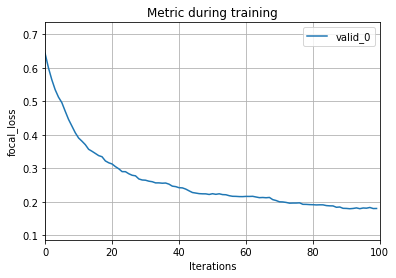

In [86]:
from lightgbm import plot_metric, plot_tree

plot_metric(model)

<AxesSubplot:>

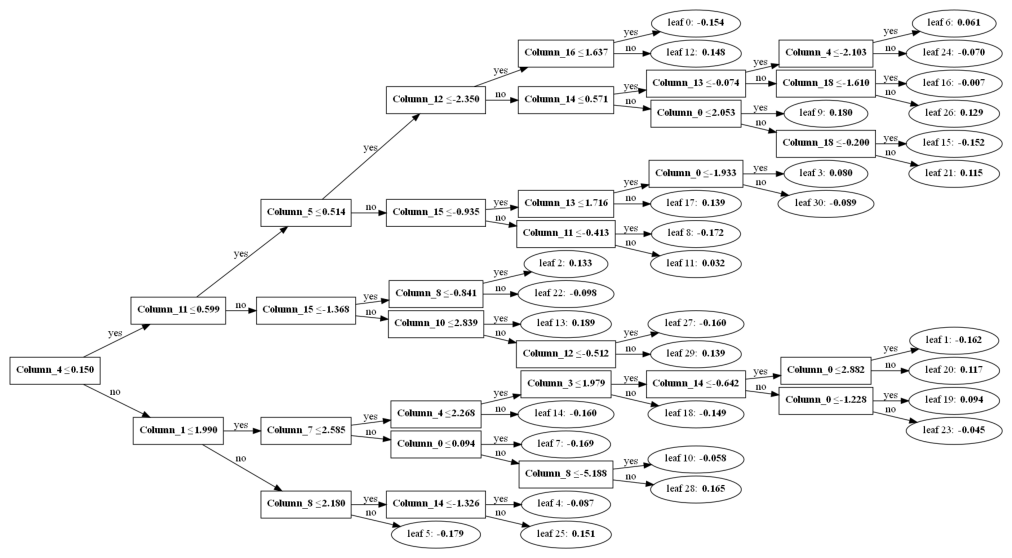

In [68]:
plot_tree(model, figsize=(20, 10))

In [ ]:
expected_